# Visualize biological trends in the data

This notebook aims to compare the biological trends in the simulated data and the original data in order to validate using this VAE to generate gene expression data.

In this simulation experiment we are preserving the experiment type but not the actual experiment so the relationship between samples within an experiment are preserved but the genes that are expressed will be different

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import random
import glob
from sklearn import preprocessing

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_1'

In [3]:
# Load data

# base dir on repo
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))          

# base dir on local machine for data storage
# os.makedirs doesn't recognize `~`
local_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../.."))  
    
latent_dim = NN_architecture.split('_')[-1]

NN_dir = base_dir + "/models/" + NN_architecture

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

mapping_file = os.path.join(
    base_dir,
    "data",
    "metadata",
    "sample_annotations.tsv")

In [4]:
# Output files
original_DEG_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_DE_original_analysis.png")

simulated_DEG_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_DE_simulated_analysis.png")

In [5]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(normalized_data.shape)
print(simulated_data.shape)

(950, 5549)
(5346, 5550)


In [6]:
normalized_data.head(10)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814
control1aerobic_Pae_G1a.CEL,0.365512,0.572967,0.417762,0.663096,0.424846,0.606590,0.378900,0.224257,0.161582,0.074461,...,0.491161,0.565151,0.595824,0.382989,0.352268,0.250905,0.362161,0.487777,0.729434,0.483384
control1_anaerobic_Pae_G1a.CEL,0.689254,0.723461,0.510094,0.801569,0.619374,0.937262,0.138600,0.298615,0.306533,0.032482,...,0.754845,0.711126,0.589279,0.542699,0.591066,0.421389,0.392671,0.686055,0.911163,0.585208
control2aerobic_Pae_G1a.CEL,0.353000,0.580626,0.302544,0.639624,0.281793,0.687343,0.462645,0.000000,0.107961,0.093163,...,0.466139,0.545104,0.487957,0.330583,0.419139,0.328478,0.298493,0.254059,0.588305,0.406311
control2_anaerobic_Pae_G1a.CEL,0.674305,0.680740,0.515478,0.747121,0.656701,0.910654,0.149744,0.262492,0.263528,0.019910,...,0.775338,0.653142,0.642205,0.550935,0.565532,0.458622,0.426767,0.701314,0.886074,0.556363
control3aerobic_Pae_G1a.CEL,0.399186,0.653977,0.328755,0.692895,0.482482,0.618446,0.308135,0.191401,0.201170,0.020375,...,0.560889,0.654797,0.493961,0.454766,0.464733,0.456465,0.348577,0.503229,0.718768,0.474649


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9f8edfc88>]],
      dtype=object)

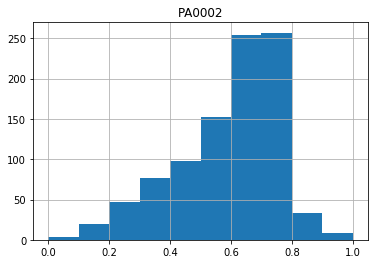

In [7]:
normalized_data.hist(column='PA0002')

In [8]:
simulated_data.head(10)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
0,0.649,0.707,0.453,0.678,0.305,0.465,0.375,0.544,0.437,0.403,...,0.497,0.673,0.509,0.645,0.174,0.462,0.229,0.508,0.687,E-MEXP-2606_0
1,0.622,0.690,0.438,0.676,0.323,0.500,0.362,0.551,0.445,0.353,...,0.511,0.640,0.516,0.644,0.188,0.487,0.264,0.524,0.678,E-MEXP-2606_0
2,0.641,0.703,0.451,0.671,0.325,0.458,0.370,0.549,0.449,0.387,...,0.512,0.684,0.523,0.655,0.169,0.453,0.256,0.538,0.695,E-MEXP-2606_0
3,0.573,0.650,0.402,0.692,0.301,0.533,0.369,0.573,0.432,0.299,...,0.534,0.534,0.494,0.622,0.227,0.529,0.303,0.489,0.647,E-MEXP-2606_0
4,0.617,0.676,0.459,0.665,0.334,0.469,0.368,0.545,0.442,0.351,...,0.527,0.679,0.529,0.647,0.186,0.459,0.289,0.553,0.686,E-MEXP-2606_0
5,0.603,0.656,0.466,0.659,0.345,0.464,0.357,0.547,0.440,0.354,...,0.553,0.681,0.531,0.639,0.196,0.451,0.320,0.575,0.687,E-MEXP-2606_0
6,0.688,0.725,0.474,0.682,0.317,0.436,0.377,0.559,0.485,0.380,...,0.519,0.681,0.500,0.663,0.143,0.355,0.250,0.541,0.718,E-MEXP-2606_0
7,0.680,0.723,0.468,0.680,0.304,0.438,0.386,0.559,0.481,0.365,...,0.520,0.665,0.484,0.659,0.141,0.336,0.244,0.544,0.716,E-MEXP-2606_0
8,0.682,0.733,0.482,0.701,0.350,0.500,0.382,0.599,0.514,0.346,...,0.522,0.683,0.527,0.682,0.135,0.361,0.266,0.560,0.741,E-MEXP-2606_0
9,0.782,0.745,0.507,0.735,0.600,0.548,0.439,0.700,0.614,0.255,...,0.692,0.697,0.565,0.702,0.088,0.400,0.705,0.764,0.803,E-GEOD-15697_1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9f28e2780>]],
      dtype=object)

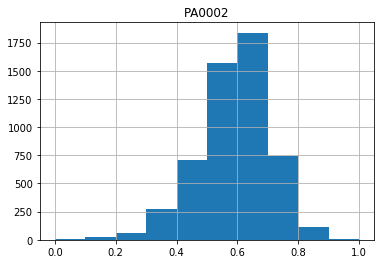

In [9]:
simulated_data.hist(column='PA0002')

In [10]:
# Read in metadata
metadata = pd.read_table(
    mapping_file, 
    header=0, 
    sep='\t', 
    index_col=0)

metadata.head()

,sample_name,ml_data_source,description,nucleic_acid,medium,genotype,od,growth_setting_1,growth_setting_2,strain,temperature,treatment,additional_notes,variant_phenotype,abx_marker,biotic_int_lv_2,biotic_int_lv_1
experiment,,,,,,,,,,,,,,,,,
E-GEOD-46947,GSM1141730 1,GSM1141730_PA01_ZnO_PZO_.CEL,Pseudomonas aeruginosa PAO1 LB aerated 5 h wi...,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,1 mM ZnO nanoparticles,Grown for 5h,NaN,NaN,NaN,NaN
E-GEOD-46947,GSM1141729 1,GSM1141729_PA01_none_PC_.CEL,Pseudomonas aeruginosa PAO1 LB aerated 5 h,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,NaN,Grown for 5h,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608059 1,GSM1608059_Planktonic_1.CEL,PAO1 WT. Planktonic. Rep1,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608060 1,GSM1608060_Planktonic_2.CEL,PAO1 WT. Planktonic. Rep2,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
E-GEOD-65882,GSM1608061 1,GSM1608061_Planktonic_3.CEL,PAO1 WT. Planktonic. Rep3,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN


In [11]:
map_experiment_sample = metadata[['sample_name', 'ml_data_source']]
map_experiment_sample.head()

,sample_name,ml_data_source
experiment,,
E-GEOD-46947,GSM1141730 1,GSM1141730_PA01_ZnO_PZO_.CEL
E-GEOD-46947,GSM1141729 1,GSM1141729_PA01_none_PC_.CEL
E-GEOD-65882,GSM1608059 1,GSM1608059_Planktonic_1.CEL
E-GEOD-65882,GSM1608060 1,GSM1608060_Planktonic_2.CEL
E-GEOD-65882,GSM1608061 1,GSM1608061_Planktonic_3.CEL


## Oxygen gradient experiment

**Question:** Is the gene expression pattern/profile of the PA1683 gene consistent between the input and the simulated data?  (The magnitude of the activity may be different but the trend should be the same)

In [12]:
# Get experiment id
experiment_id = 'E-GEOD-52445'

In [13]:
# Get original samples associated with experiment_id
selected_mapping = map_experiment_sample.loc[experiment_id]
original_selected_sample_ids = list(selected_mapping['ml_data_source'].values)

selected_original_data = normalized_data.loc[original_selected_sample_ids]

selected_original_data.head(5)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM1267086_HZI1981_G1a.CEL,0.646862,0.679788,0.403342,0.590506,0.336135,0.354079,0.873178,0.550167,0.545020,0.161909,...,0.289186,0.535974,0.557875,0.526033,0.686710,0.192233,0.445449,0.448403,0.696176,0.674890
GSM1267087_HZI1950_Pae_G1a.CEL,0.672238,0.742309,0.333766,0.675540,0.327351,0.188582,0.941649,0.664669,0.504285,0.188626,...,0.224229,0.530254,0.539841,0.570655,0.703041,0.146765,0.375490,0.530460,0.659498,0.693848
GSM1267088_HZI1951_Pae_G1a.CEL,0.606429,0.717016,0.389281,0.692173,0.371449,0.208108,0.894712,0.699663,0.620941,0.168557,...,0.333041,0.487957,0.579132,0.679318,0.784700,0.211256,0.438018,0.702069,0.796113,0.764060
GSM1267089_HZI1952_Pae_G1a.CEL,0.593320,0.720939,0.307024,0.733425,0.391951,0.282023,0.930575,0.718343,0.599914,0.162725,...,0.380829,0.443571,0.520383,0.587204,0.799703,0.151036,0.329585,0.632248,0.774848,0.772045
GSM1267090_HZI1953a_Pae_G1a.CEL,0.559336,0.684122,0.313812,0.621583,0.431680,0.276904,0.776492,0.661612,0.574422,0.154941,...,0.471574,0.492006,0.511409,0.630100,0.734772,0.187909,0.411634,0.595385,0.788193,0.736931


In [14]:
# Get first matching experiment id
match_experiment_id = ''
for experiment_name in simulated_data['experiment_id'].values:
    if experiment_name.split("_")[0] == experiment_id:
        match_experiment_id = experiment_name        

In [15]:
# Get simulated samples associated with experiment_id
selected_simulated_data = simulated_data[simulated_data['experiment_id'] == match_experiment_id]

# Map sample ids from original data to simulated data
selected_simulated_data.index = original_selected_sample_ids

selected_simulated_data.head(5)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
GSM1267086_HZI1981_G1a.CEL,0.476,0.471,0.316,0.382,0.325,0.354,0.465,0.200,0.075,0.361,...,0.534,0.450,0.067,0.297,0.180,0.176,0.287,0.416,0.560,E-GEOD-52445_592
GSM1267087_HZI1950_Pae_G1a.CEL,0.451,0.525,0.350,0.482,0.259,0.286,0.571,0.223,0.137,0.294,...,0.464,0.482,0.086,0.232,0.182,0.181,0.257,0.360,0.455,E-GEOD-52445_592
GSM1267088_HZI1951_Pae_G1a.CEL,0.518,0.515,0.375,0.461,0.334,0.405,0.487,0.272,0.159,0.321,...,0.514,0.507,0.162,0.374,0.197,0.230,0.371,0.466,0.578,E-GEOD-52445_592
GSM1267089_HZI1952_Pae_G1a.CEL,0.487,0.519,0.367,0.487,0.307,0.363,0.514,0.249,0.154,0.319,...,0.488,0.528,0.151,0.336,0.195,0.232,0.341,0.440,0.542,E-GEOD-52445_592
GSM1267090_HZI1953a_Pae_G1a.CEL,0.553,0.511,0.410,0.546,0.404,0.452,0.486,0.323,0.220,0.280,...,0.535,0.560,0.291,0.501,0.217,0.310,0.442,0.497,0.621,E-GEOD-52445_592


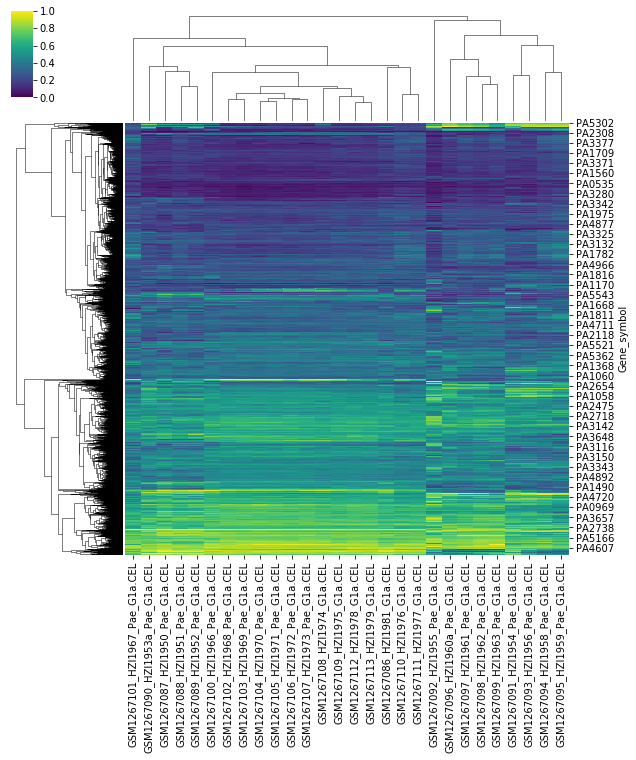

In [16]:
# Plot original data
sns.clustermap(selected_original_data.T, cmap="viridis")

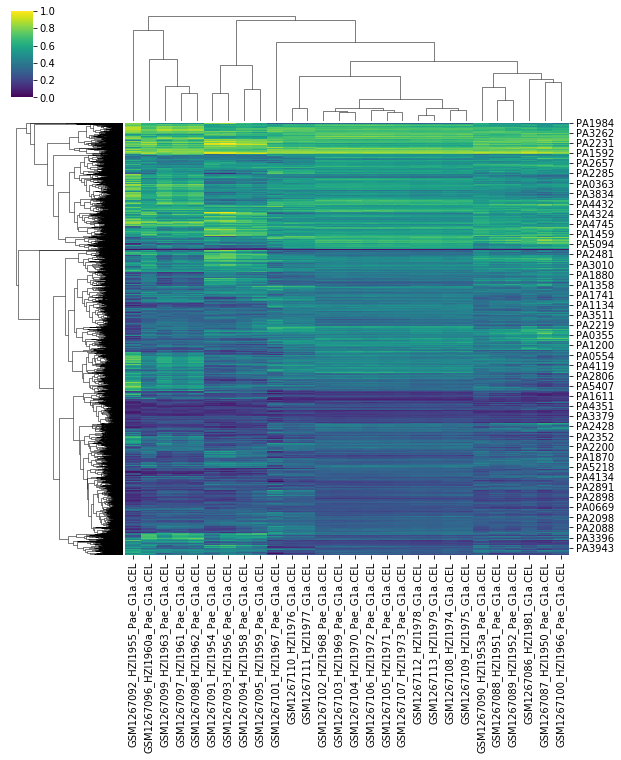

In [17]:
# Plot simulated
selected_simulated_data = selected_simulated_data.drop(columns=['experiment_id'])
sns.clustermap(selected_simulated_data.T, cmap="viridis")

## Two different conditions

In [18]:
# Get experiment id
#experiment_id = 'E-GEOD-43641'
experiment_id = 'E-GEOD-51409'
#experiment_id = 'E-GEOD-49759'
#experiment_id = 'E-GEOD-30967'

In [19]:
# Get original samples associated with experiment_id
selected_mapping = map_experiment_sample.loc[experiment_id]
original_selected_sample_ids = list(selected_mapping['ml_data_source'].values)

selected_original_data = normalized_data.loc[original_selected_sample_ids]

selected_original_data.head(10)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
GSM1244967_PAO1-22-replicate-01.CEL,0.707632,0.591295,0.556849,0.554163,0.108815,0.491500,0.478875,0.349469,0.444959,0.182429,...,0.769653,0.240919,0.631863,0.203261,0.259068,0.244132,0.173414,0.104872,0.341973,0.725593
GSM1244968_PAO1-22-replicate-02.CEL,0.652467,0.589207,0.582165,0.577393,0.133924,0.486844,0.471427,0.466365,0.407019,0.227946,...,0.793967,0.146011,0.646168,0.280495,0.246450,0.265938,0.189988,0.131713,0.313469,0.728243
GSM1244969_PAO1-22-replicate-03.CEL,0.665609,0.587199,0.526715,0.511682,0.174225,0.559947,0.467768,0.389269,0.427624,0.221704,...,0.717929,0.225048,0.633922,0.185355,0.260177,0.149668,0.213280,0.141645,0.361939,0.722334
GSM1244970_PAO1-37-replicate-01.CEL,0.638473,0.579994,0.530250,0.519711,0.392989,0.692947,0.556974,0.544441,0.436963,0.225269,...,0.731624,0.348890,0.618727,0.387166,0.494027,0.206227,0.180011,0.133494,0.638442,0.931801
GSM1244971_PAO1-37-replicate-02.CEL,0.710691,0.570855,0.446056,0.563187,0.219645,0.554107,0.498864,0.449821,0.467584,0.246211,...,0.766107,0.365663,0.615191,0.452861,0.506253,0.166401,0.330936,0.180199,0.641981,0.928349
GSM1244972_PAO1-37-replicate-03.CEL,0.646180,0.640573,0.504316,0.526256,0.321711,0.656524,0.584026,0.525445,0.317248,0.236268,...,0.705381,0.331700,0.588271,0.370655,0.468510,0.266316,0.106825,0.138542,0.633818,0.931560


In [20]:
# Get first matching experiment id
match_experiment_id = ''
for experiment_name in simulated_data['experiment_id'].values:
    if experiment_name.split("_")[0] == experiment_id:
        match_experiment_id = experiment_name 

In [21]:
# Get simulated samples associated with experiment_id
selected_simulated_data = simulated_data[simulated_data['experiment_id'] == match_experiment_id]

# Map sample ids from original data to simulated data
selected_simulated_data.index = original_selected_sample_ids

selected_simulated_data.head(5)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
GSM1244967_PAO1-22-replicate-01.CEL,0.516,0.644,0.437,0.705,0.305,0.482,0.436,0.411,0.318,0.204,...,0.414,0.488,0.256,0.255,0.267,0.225,0.344,0.398,0.508,E-GEOD-51409_527
GSM1244968_PAO1-22-replicate-02.CEL,0.514,0.635,0.435,0.699,0.303,0.492,0.429,0.403,0.312,0.204,...,0.404,0.485,0.254,0.252,0.272,0.217,0.338,0.397,0.519,E-GEOD-51409_527
GSM1244969_PAO1-22-replicate-03.CEL,0.520,0.653,0.444,0.712,0.311,0.475,0.436,0.421,0.326,0.207,...,0.424,0.492,0.260,0.258,0.264,0.232,0.353,0.402,0.505,E-GEOD-51409_527
GSM1244970_PAO1-37-replicate-01.CEL,0.537,0.647,0.445,0.649,0.405,0.414,0.385,0.485,0.386,0.278,...,0.509,0.532,0.405,0.471,0.315,0.353,0.475,0.518,0.591,E-GEOD-51409_527
GSM1244971_PAO1-37-replicate-02.CEL,0.542,0.650,0.449,0.653,0.402,0.415,0.386,0.486,0.387,0.275,...,0.503,0.538,0.407,0.473,0.311,0.352,0.475,0.518,0.598,E-GEOD-51409_527


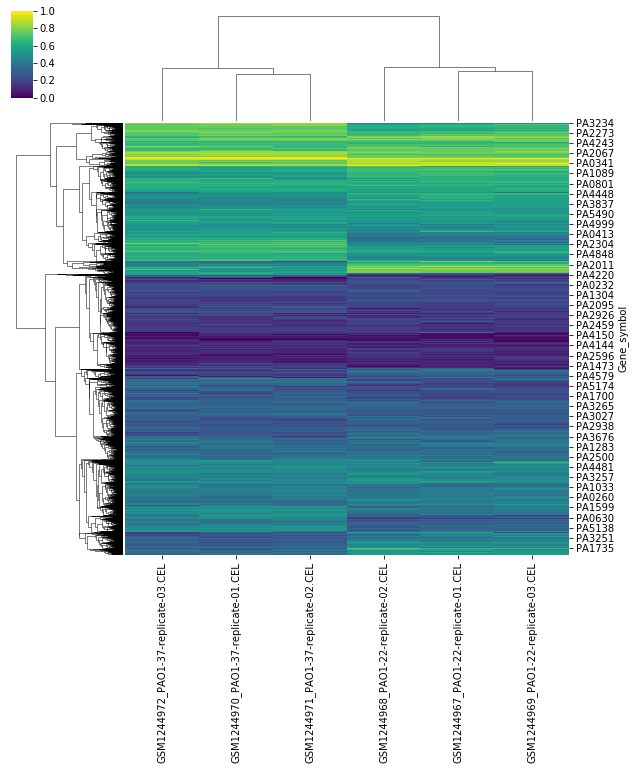

In [22]:
# Plot original data
sns.clustermap(selected_original_data.T, cmap="viridis")

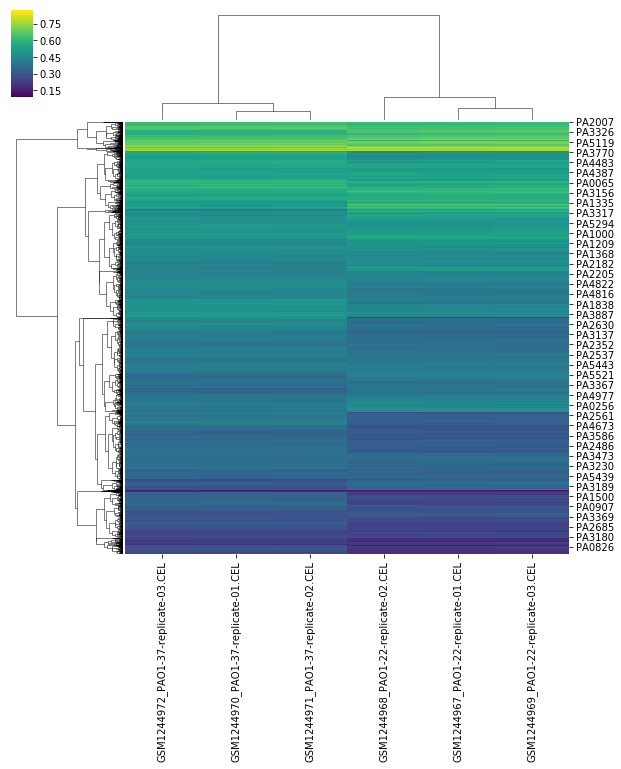

In [23]:
# Plot simulated
selected_simulated_data = selected_simulated_data.drop(columns=['experiment_id'])
with sns.color_palette("viridis"):
    sns.clustermap(selected_simulated_data.T, cmap="viridis")

## Output selected gene expression data

We will use this to put into R script to identify differentially expressed genes (DEGs)

In [24]:
selected_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "selected_simulated_data.txt")

selected_original_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "selected_original_data.txt")

selected_simulated_data.to_csv(
        selected_simulated_data_file, float_format='%.3f', sep='\t')

selected_original_data.to_csv(
        selected_original_data_file, float_format='%.3f', sep='\t')

## Find differentially expressed genes

In [25]:
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

In [26]:
%%R
source("/home/alexandra/Documents/Repos/Batch_effects_simulation/scripts/functions/DE_analysis.R")
experiment_id = 'E-GEOD-51409'
find_DEGs("metadata_deg_phosphate", experiment_id)
#find_DEGs("metadata_deg_temp")

[1] 4671
[1] 2053


## Visualize gene expression data using DEGs

In [27]:
# Import list of DEGs
DEG_sim_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "sign_DEG_sim_"+experiment_id+".txt")

DEG_original_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "sign_DEG_original_"+experiment_id+".txt")

In [28]:
# Read data
DEG_sim_data = pd.read_table(
    DEG_sim_file,
    header=0,
    sep='\t',
    index_col=0)

DEG_original_data = pd.read_table(
    DEG_original_file,
    header=0,
    sep='\t',
    index_col=0)

DEG_sim_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
Gene,,,,,,
PA1072,0.181000,0.540500,55.937730,1.780915e-10,1.766039e-07,15.013083
PA0896,0.218333,0.512500,52.461796,2.777531e-10,1.766039e-07,14.609670
PA4881,-0.146333,0.170167,-52.244681,2.858474e-10,1.766039e-07,14.583235
PA5565,-0.213000,0.361500,-51.370520,3.212853e-10,1.766039e-07,14.475246
PA3079,0.134000,0.367333,50.833192,3.455559e-10,1.766039e-07,14.407606


### Select top differentially expressed genes

In [29]:
DEG_sim_data.sort_values(by=['adj.P.Val'])
DEG_sim_data = DEG_sim_data.iloc[0:10,]

DEG_sim_data

,logFC,AveExpr,t,P.Value,adj.P.Val,B
Gene,,,,,,
PA1072,0.181000,0.540500,55.937730,1.780915e-10,1.766039e-07,15.013083
PA0896,0.218333,0.512500,52.461796,2.777531e-10,1.766039e-07,14.609670
PA4881,-0.146333,0.170167,-52.244681,2.858474e-10,1.766039e-07,14.583235
PA5565,-0.213000,0.361500,-51.370520,3.212853e-10,1.766039e-07,14.475246
PA3079,0.134000,0.367333,50.833192,3.455559e-10,1.766039e-07,14.407606
PA4561,-0.156333,0.270833,-50.026240,3.860527e-10,1.766039e-07,14.304170
PA2320,-0.147667,0.308167,-49.762929,4.004224e-10,1.766039e-07,14.269927
PA2276,-0.126333,0.290167,-49.549207,4.125366e-10,1.766039e-07,14.241952
PA1970,-0.147000,0.232500,-48.661668,4.675390e-10,1.766039e-07,14.124015


In [30]:
DEG_original_data.sort_values(by=['adj.P.Val'])
DEG_original_data = DEG_original_data.iloc[0:10,]

DEG_original_data

,logFC,AveExpr,t,P.Value,adj.P.Val,B
Gene,,,,,,
PA4175,0.589000,0.651833,34.620646,3.526984e-09,0.000014,11.684663
PA0887,-0.725333,0.427667,-31.980175,6.174131e-09,0.000014,11.242549
PA0535,0.577000,0.702500,29.887212,9.950790e-09,0.000014,10.849300
PA0534,0.507333,0.709667,29.195492,1.173611e-08,0.000014,10.709999
PA4648,0.520667,0.721000,28.767723,1.302223e-08,0.000014,10.621364
PA1914,0.495667,0.592167,27.539515,1.770621e-08,0.000016,10.355729
PA1875,0.464333,0.602167,25.418243,3.111756e-08,0.000025,9.854395
PA0899,0.518667,0.496000,24.398033,4.149669e-08,0.000027,9.591971
PA3022,-0.420333,0.786500,-24.201455,4.392257e-08,0.000027,9.539680


In [31]:
# Get DEG ids
sim_gene_ids = list(DEG_sim_data.index)
original_gene_ids = list(DEG_original_data.index)

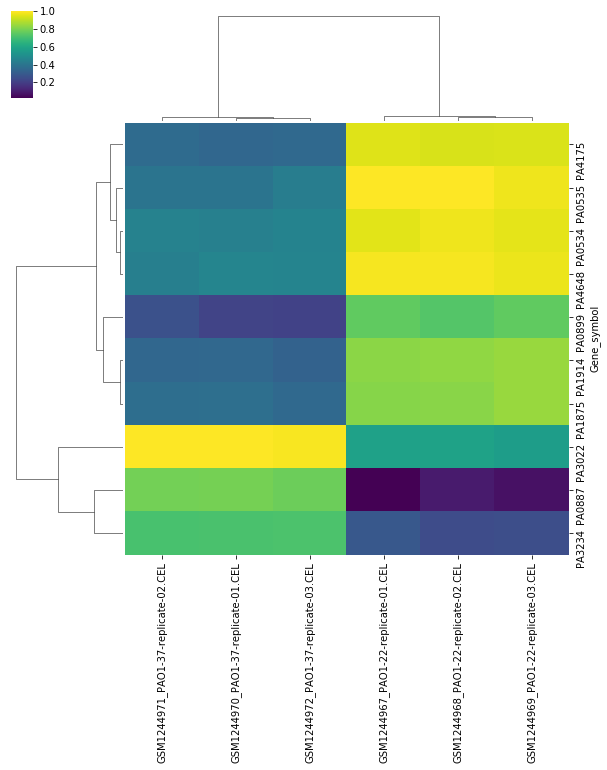

In [32]:
# Plot original data
selected_original_DEG_data = selected_original_data[original_gene_ids]
#sns.clustermap(selected_original_DEG_data.T)
f = sns.clustermap(selected_original_DEG_data.T, cmap="viridis")
f.savefig(original_DEG_file, dpi=300)

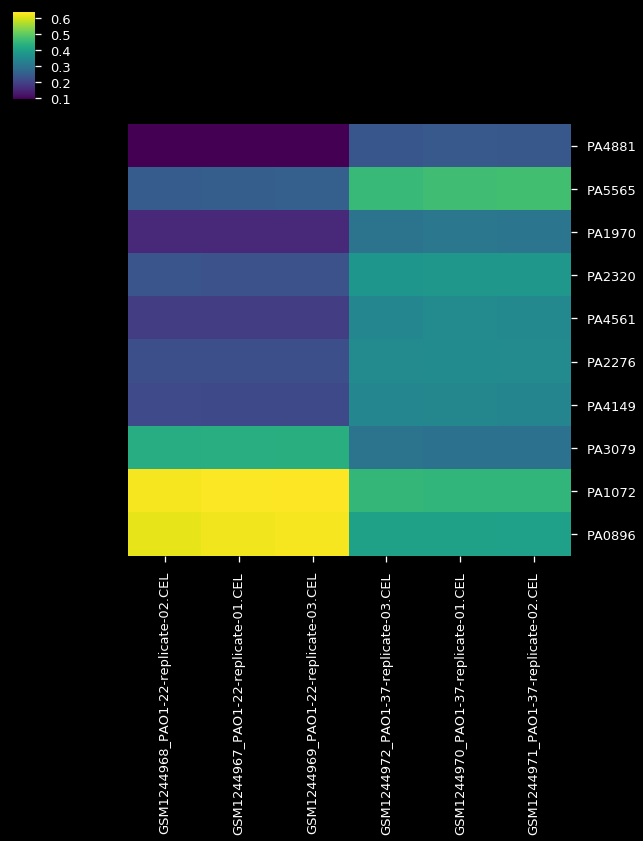

In [41]:
# Plot simulated
#selected_simulated_data = selected_simulated_data.drop(columns=['experiment_id'])
selected_simulated_DEG_data = selected_simulated_data[sim_gene_ids]
#sns.clustermap(selected_simulated_DEG_data.T)
import matplotlib.pyplot as plt
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
#sns.set_style("darkgrid")
sns.clustermap(selected_simulated_DEG_data.T, cmap="viridis")
#f.savefig(simulated_DEG_file, dpi=300)